# Mean-Variance Optimization

### Headings

In [162]:
import pandas as pd
import numpy as np
import datetime
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib notebook

### Read Data

In [163]:
rf = 0.015

In [176]:
# read data from file
aapl = pd.read_csv('./AAPL.csv', sep=',', index_col=0, header=0, parse_dates=True)
msft = pd.read_csv('./MSFT.csv', sep=',', index_col=0, header=0, parse_dates=True)
gm = pd.read_csv('./GM.csv', sep=',', index_col=0, header=0, parse_dates=True)
stock_price = pd.DataFrame({'AAPL':aapl['Adj Close'],'MSFT':msft['Adj Close'],'GM':gm['Adj Close']})
stock_return = stock_price.pct_change()[1:]    # use percentage return

#stock_return['Cash'] = rf
stock_return.head()

,AAPL,GM,MSFT
Date,,,
2013-10-15,0.005322,-0.017832,0.001161
2013-10-16,0.004873,0.012392,0.004349
2013-10-17,0.006765,0.015086,0.008083
2013-10-18,0.008701,0.006450,0.001145
2013-10-21,0.024505,-0.010867,0.000858


### Major Functions for portfolio

In [165]:
# Average Return for all asset in certain period[start, end)
def avg_return(start, end):
    temp_df = stock_return.copy()
    temp_df = temp_df[(temp_df.index>=start)&(temp_df.index<end)]
    avg_return = np.mean(temp_df)
    return pd.DataFrame({'Return':avg_return*252})    # Annualized Return

In [166]:
# Average Covariance Matrix for all asset in certain period[start, end)
def cov(start, end):
    temp_df = stock_return.copy()
    temp_df = temp_df[(temp_df.index>=start)&(temp_df.index<end)]
    return temp_df.cov()*252    # Annualized Covariance Matrix

In [167]:
# Given a portfolio(Weight--W, Return--R, Covariance--C), calculate the mean and variance of return
def port_mean(W, R):
    return float(np.dot(W,R))
def port_var(W, C):
    return np.dot(np.dot(W,C),W)
def port_mean_var(W, R, C):
    return port_mean(W,R), port_var(W,C)

### Some Optimize Method

In [168]:
# Given a expected return, minimize the variance
def solve_min_var(R, C, r):
    def fitness(W, R, C, r): # Minimize this Function
        mean, var = port_mean_var(W, R, C)
        penalty = 10000*abs(r-mean) # use penalty to constrain the return 
        return var + penalty
    n = len(R)
    W = np.ones([n])/n  # initialize W as equal weights
    b_ = [(0.,1.) for __ in range(n)]    # W should be in range(0,1), no short or leverage
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})   # sum of weight is 1
    optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
    return optimized.x

In [169]:
# Given a variance tolerance, maximize the expected return
def solve_max_return(R, C, v):
    def fitness(W, R, C, v):  # Minimize this Function
        mean, var = port_mean_var(W, R, C)
        penalty = 10000*abs(var-v) # use penalty to constrain the return 
        return -mean + penalty
    n = len(R)
    W = np.ones([n])/n  # initialize W as equal weights
    b_ = [(0.,1.) for __ in range(n)]  # W should be in range(0,1), no short or leverage
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # sum of weight is 1
    optimized = scipy.optimize.minimize(fitness, W, (R, C, v), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [170]:
# Calculate the tangent portfolio
def solve_tangent(R, C, rf):
    def fitness(W, R, C, rf):  # Minimize this Function
        mean, var = port_mean_var(W, R, C)
        util = (mean - rf) / np.sqrt(var)  # utility = Sharpe ratio
        return 1/util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = np.ones([n]) / n  # initialize W as equal weights
    b_ = [(0., 1.) for __ in range(n)]  # W should be in range(0,1), no short or leverage
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # sum of weight is 1
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

### Draw the Effective Frontier

In [171]:
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):    # For a given level return, find the minimum variance
        mean, var = port_mean_var(W, R, C)
        penalty = 10000 * abs(mean - r)   # use penalty to constrain the return 
        return var + penalty
    
    frontier_mean, frontier_var = [], []
    n = len(R)  # Number of assets
    for r in np.linspace(np.min(R), np.max(R), num=500):  # Iterate through the range of returns on Y axis
        W = np.ones([n]) / n  # initialize W as equal weights
        b_ = [(0., 1.) for __ in range(n)]  # W should be in range(0,1), no short or leverage
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # sum of weight is 1
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
            
        # Add point coordinate
        frontier_mean.append(port_mean(optimized.x, R))  
        frontier_var.append(port_var(optimized.x, C))
    return frontier_mean, frontier_var

### Plot the Effective Frontier

In [172]:
start = pd.Timestamp('2013-10-15')+ pd.Timedelta('150d')
end = start + pd.Timedelta('150d')
R = avg_return(start, end)
C = cov(start, end)

In [173]:
y, x = solve_frontier(R, C, rf)
x = np.sqrt(x)

BaseException: Positive directional derivative for linesearch

In [174]:
w_t = solve_tangent(R, C, rf)
y_t, x_t = port_mean_var(w_t, R, C)
x_t = np.sqrt(x_t)

In [175]:
plt.figure()
plt.plot(x, y, 'o', markersize=1)
plt.title('Effective Frontier')
plt.xlabel('volatility')
plt.ylabel('return')
plt.plot([0,x_t],[rf,y_t])    # plot the CML line

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (8,) and (500,)

### Calculate the Back Test Result

In [180]:
portfolio = stock_return.copy()
portfolio['W_AAPL'] = np.zeros([len(portfolio)])
portfolio['W_MSFT'] = np.zeros([len(portfolio)])
portfolio['W_GM'] = np.zeros([len(portfolio)])
portfolio['Cash'] = np.zeros([len(portfolio)])
portfolio['daily_return'] = np.zeros([len(portfolio)])

In [182]:
# Back Test on 5 years, rebalance every 100 days
W_aapl,W_msft,W_gm = [],[],[]
start = pd.Timestamp('2013-10-15')
end = pd.Timestamp('2018-10-12')
dates = pd.date_range('2013-10-15','2018-10-12' , freq='200d')
for i,date in enumerate(dates):
    if i == 0:
        continue
    # solve the optimized weight before date, and implement it before dates[i+1]
    R = avg_return(dates[i-1],date)
    C = cov(dates[i-1],date)
    W_AAPL, W_MSFT, W_GM = solve_tangent(R,C,rf)    # suppose the strategy is to min var under return 0.25
    W_CASH = 0
    '''
    mean_t, var_t = port_mean_var([W_AAPL, W_MSFT, W_GM],R,C)
    if v<var_t:
        W_CASH = 1-np.sqrt(v)/np.sqrt(var_t)
    if r<mean_t:
        W_CASH = 1-(r-rf)/(mean_t-rf)
    '''

    # renew the weight 
    portfolio.loc[date:, 'W_AAPL'] = W_AAPL*(1-W_CASH)
    portfolio.loc[date:, 'W_MSFT'] = W_MSFT*(1-W_CASH)
    portfolio.loc[date:, 'W_GM'] = W_GM*(1-W_CASH)
    W_aapl.append(W_AAPL*(1-W_CASH))
    W_msft.append(W_MSFT*(1-W_CASH))
    W_gm.append(W_GM*(1-W_CASH))


In [183]:
portfolio['daily_return'] = portfolio['W_AAPL']*portfolio['AAPL']+portfolio['W_MSFT']*portfolio['MSFT']+portfolio['W_GM']*portfolio['GM']
portfolio['daily_return_1'] = portfolio['daily_return']+1
portfolio['PnL'] = portfolio['daily_return_1'].cumprod()    # suppose we invest 1 dollar at the beginning

In [184]:
vol = np.std(portfolio['daily_return'])*np.sqrt(252)
mu = np.mean(portfolio['daily_return'])*252
sharpe = (mu-rf)/vol
result = pd.DataFrame({'Return': mu, 'Sharpe Ratio': sharpe, 'Volatility':vol}, index = {'Min Var'})
result

,Return,Sharpe Ratio,Volatility
Min Var,0.15139,0.646517,0.210961


<IPython.core.display.Javascript object>


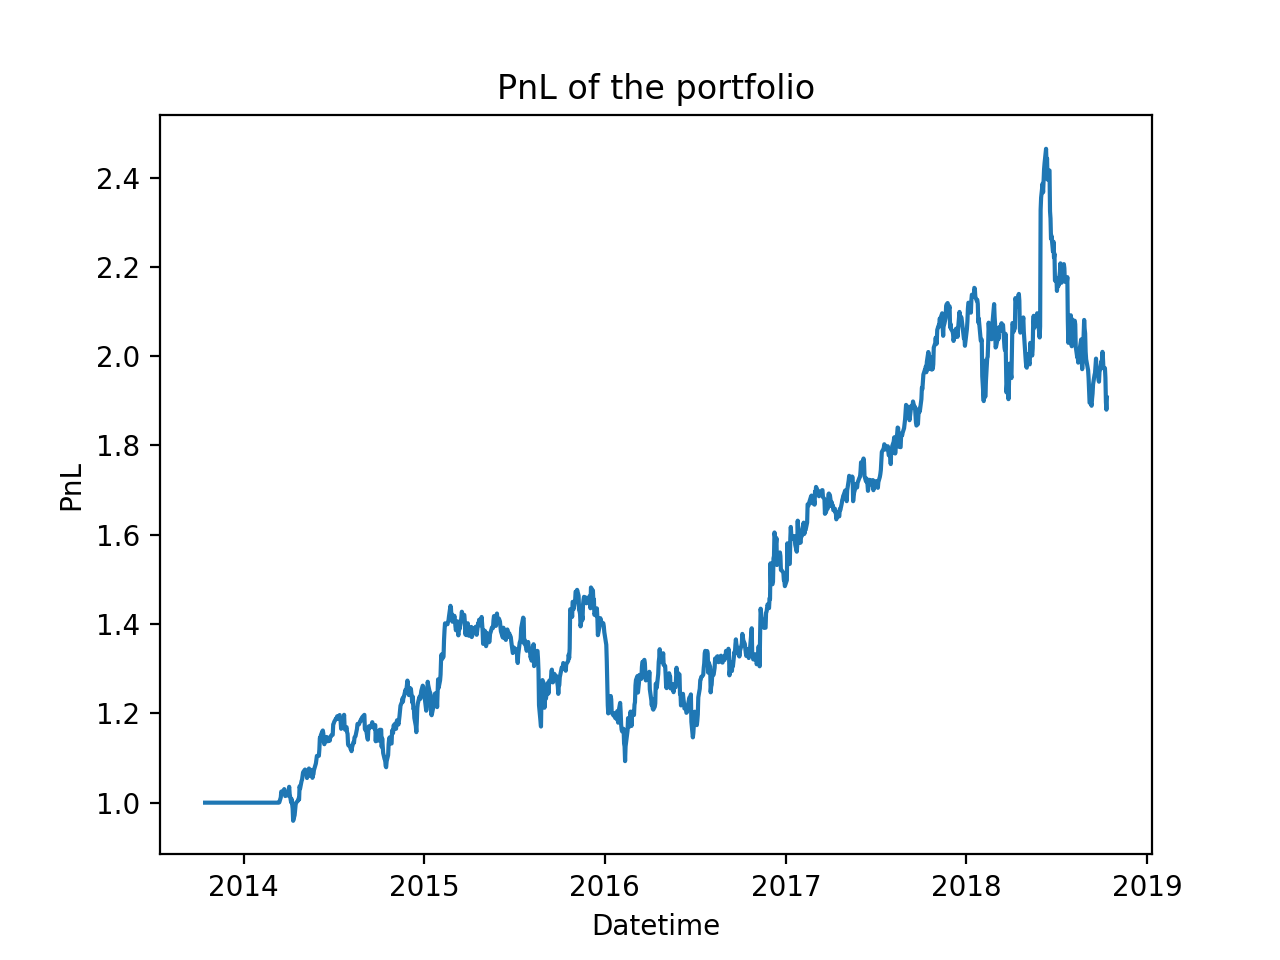

Text(0,0.5,'PnL')

In [185]:
plt.figure()
plt.plot(portfolio['PnL'])
plt.title('PnL of the portfolio')
plt.xlabel('Datetime')
plt.ylabel('PnL')

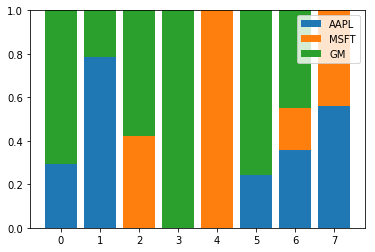

In [156]:
plt.figure()
n = len(W_aapl)
x = range(n)
plt.bar(x, height = W_aapl, label = 'AAPL')
plt.bar(x, height = W_msft, bottom=W_aapl, label='MSFT')
plt.bar(x, height = W_gm, bottom=np.array(W_aapl)+np.array(W_msft), label='GM')
plt.legend()

In [186]:
W_aapl

[0.518278538896253,
 0.6111523452898028,
 0.512141820656223,
 1.4954704141700859e-12,
 4.9786563760534364e-14,
 0.3916269535659252,
 0.6567591004477393,
 0.0,
 0.5890025714773022]